# Train and test of the model

#### Importamos librerias

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

#### Cargamos los datos

In [64]:
all_seasons_data = pd.read_csv('all_seasons_no_outliers.csv')

In [65]:
all_seasons_data.head()

,playerId,tid,tp,mins,g,ga,oaa,pae,pw,ps,...,tsa,wc,br,pla,pc,pid,avg,Temporada,Jornada,position
0,81,3,12,70,1,0,0,0,0,0,...,2,1,5,11,0,3,12.0,2020,10,mediocentro
1,327,19,12,77,1,1,0,0,0,0,...,1,0,1,8,0,3,12.0,2020,10,mediocentro
2,576,21,12,72,1,1,0,3,0,0,...,1,0,2,14,0,4,12.0,2020,10,delantero
3,184,9,11,90,0,0,0,0,0,0,...,0,0,10,17,0,1,11.0,2020,10,portero
4,215,11,11,90,0,1,1,6,0,0,...,1,3,6,14,0,3,11.0,2020,10,mediocentro


In [66]:
all_seasons_data = all_seasons_data.drop(columns='position')

Vamos a calcular metricas que nos muestren la evaluación de los jugadores en las últimas 3,5,10 jornadas

In [67]:
num_matchweeks = [3,5,10]

grouped = all_seasons_data.sort_values(['Temporada', 'Jornada']).groupby('playerId')

rolling_avg_columns = ['mins', 'g', 'ga', 'oaa', 'pae', 'br', 'tsa', 'wc', 'pla']

rolling_avgs = []
for num_matchweeks in [3, 5, 10]:
    rolling_avg = grouped.rolling(window=num_matchweeks, min_periods=1).mean().reset_index(level=0, drop=True)
    rolling_avg = rolling_avg[rolling_avg_columns]
    rolling_avg.columns = [f'avg_{col}_last{num_matchweeks}w' for col in rolling_avg_columns]
    rolling_avgs.append(rolling_avg)

rolling_avg_all = pd.concat(rolling_avgs, axis=1)


efficiency_metrics = all_seasons_data.copy()
efficiency_metrics['goals_per_min'] = efficiency_metrics['g'] / efficiency_metrics['mins'].replace(0, 1)
efficiency_metrics['assists_per_min'] = efficiency_metrics['ga'] / efficiency_metrics['mins'].replace(0, 1)
efficiency_metrics['recoveries_per_game'] = efficiency_metrics['br'] / efficiency_metrics['mins'].replace(0, 1) * 90

enhanced_data = pd.concat([all_seasons_data, rolling_avg_all, efficiency_metrics[['goals_per_min', 'assists_per_min', 'recoveries_per_game']]], axis=1)

enhanced_data.head()


,playerId,tid,tp,mins,g,ga,oaa,pae,pw,ps,...,avg_ga_last10w,avg_oaa_last10w,avg_pae_last10w,avg_br_last10w,avg_tsa_last10w,avg_wc_last10w,avg_pla_last10w,goals_per_min,assists_per_min,recoveries_per_game
0,81,3,12,70,1,0,0,0,0,0,...,0.000000,0.000000,0.200000,3.300000,0.600000,0.900000,7.700000,0.014286,0.000000,6.428571
1,327,19,12,77,1,1,0,0,0,0,...,0.200000,0.000000,0.400000,3.700000,0.100000,0.300000,5.800000,0.012987,0.012987,1.168831
2,576,21,12,72,1,1,0,3,0,0,...,0.222222,0.111111,1.888889,2.777778,0.555556,1.444444,10.888889,0.013889,0.013889,2.500000
3,184,9,11,90,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,8.700000,0.000000,0.000000,17.600000,0.000000,0.000000,10.000000
4,215,11,11,90,0,1,1,6,0,0,...,0.250000,0.625000,1.750000,6.625000,0.500000,2.750000,18.375000,0.000000,0.011111,6.000000


In [68]:
enhanced_data.columns

Index(['playerId', 'tid', 'tp', 'mins', 'g', 'ga', 'oaa', 'pae', 'pw', 'ps',
       's', 'ec', 'og', 'gc', 'yc', 'syc', 'rc', 'tsa', 'wc', 'br', 'pla',
       'pc', 'pid', 'avg', 'Temporada', 'Jornada', 'avg_mins_last3w',
       'avg_g_last3w', 'avg_ga_last3w', 'avg_oaa_last3w', 'avg_pae_last3w',
       'avg_br_last3w', 'avg_tsa_last3w', 'avg_wc_last3w', 'avg_pla_last3w',
       'avg_mins_last5w', 'avg_g_last5w', 'avg_ga_last5w', 'avg_oaa_last5w',
       'avg_pae_last5w', 'avg_br_last5w', 'avg_tsa_last5w', 'avg_wc_last5w',
       'avg_pla_last5w', 'avg_mins_last10w', 'avg_g_last10w', 'avg_ga_last10w',
       'avg_oaa_last10w', 'avg_pae_last10w', 'avg_br_last10w',
       'avg_tsa_last10w', 'avg_wc_last10w', 'avg_pla_last10w', 'goals_per_min',
       'assists_per_min', 'recoveries_per_game'],
      dtype='object')

Vamos a guardar los datos en un archivo llamado enhanced

In [69]:
enhanced_data.to_csv('enhanced_data.csv', index=False)

In [70]:
enhanced_data.drop(columns='avg',inplace=True)

Se van a dividir los datos en 2 conjuntos: 
* Train: tomará el 80% de los datos
* Test: tomará el 20% de los datos acorde a test_size=0.2
* random_state será la semilla aleatoria se utilizará para la división

In [71]:
features = enhanced_data.drop(columns=['tp', 'Temporada', 'Jornada'])
target = enhanced_data['tp']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Training models

#### Regresión lineal

In [72]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

#### Random Forest Regressor

In [73]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred_rf = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

In [75]:
from sklearn.model_selection import cross_val_score
rf_regressor = RandomForestRegressor(random_state=42)


cv_scores = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='r2')

rf_regressor.fit(X_train, y_train)

feature_importances = rf_regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Puntuaciones de validación cruzada (R2):", cv_scores)
print("Media de las puntuaciones de validación cruzada:", np.mean(cv_scores))

Puntuaciones de validación cruzada (R2): [0.94837769 0.94849201 0.94549556 0.94624222 0.94877507]
Media de las puntuaciones de validación cruzada: 0.947476510374079


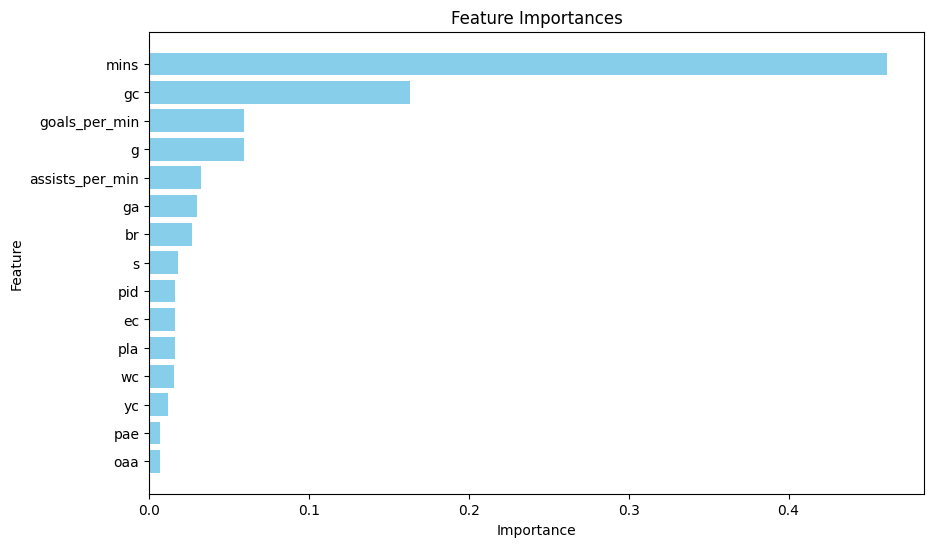

In [17]:
importance_df = importance_df.head(15)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis() 
plt.savefig('./figures/feature_importance.png')

plt.show()

#### Visualización regresión

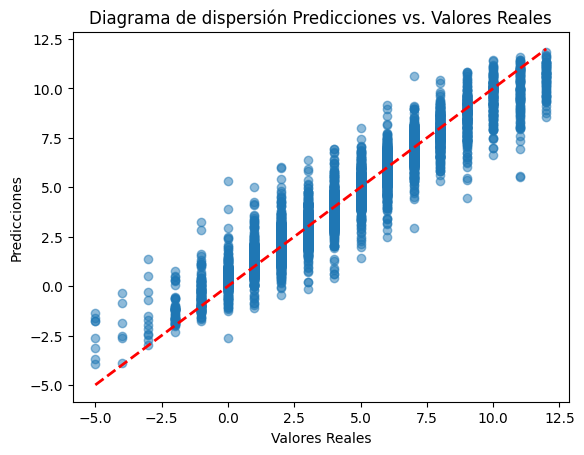

In [21]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Diagrama de dispersión Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.savefig('./figures/scatter_random_forest.png')
plt.show()

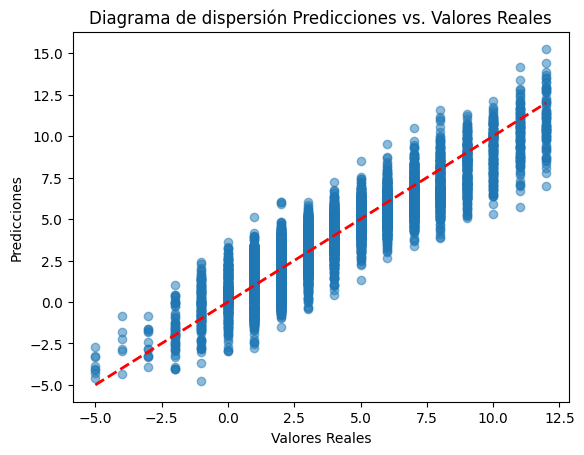

In [22]:
plt.scatter(y_test, lr_predictions, alpha=0.5)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Diagrama de dispersión Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.savefig('./figures/scatter_linear_regression.png')
plt.show()

### Model evaluation

In [74]:
print("Linear Regression: MSE =", lr_mse, "R2 =", lr_r2)
print("Random Forest: MSE =", mse, "R2 =", r2)

Linear Regression: MSE = 1.0837169049181496 R2 = 0.8794030174492148
Random Forest: MSE = 0.4499224406421215 R2 = 0.9499322300158982


### Model pickle

In [59]:
import pickle

with open('../pickles/rf_regressor.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

print(f"Model saved to ../pickles/rf_regressor.pkl")

Model saved to ../pickles/rf_regressor.pkl


### Make the prediction data

In [61]:
latest_season = enhanced_data['Temporada'].max()
last_matchweek = enhanced_data[enhanced_data['Temporada'] == latest_season]['Jornada'].max()

latest_season, last_matchweek

(2023, 20)

In [62]:
latest_data = enhanced_data[(enhanced_data['Temporada'] == latest_season) & 
                            (enhanced_data['Jornada'] == last_matchweek)]
latest_data

,playerId,tid,tp,mins,g,ga,oaa,pae,pw,ps,...,avg_tsa_last10w,avg_wc_last10w,avg_pla_last10w,goals_per_min,assists_per_min,recoveries_per_game,pid_1,pid_2,pid_3,pid_4
49560,365,21,11,13,1,0,0,0,0,0,...,0.2,0.1,5.0,0.076923,0.000000,0.000000,False,True,False,False
49561,856,21,9,77,0,1,1,0,0,0,...,0.0,0.6,8.0,0.000000,0.012987,5.844156,False,False,True,False
49562,567,17,9,90,1,0,0,0,0,0,...,1.1,1.7,23.4,0.011111,0.000000,5.000000,False,False,False,True
49563,786,17,9,90,0,0,2,6,0,0,...,0.2,0.8,6.8,0.000000,0.000000,3.000000,False,False,False,True
49564,1155,21,9,72,1,0,0,1,0,0,...,0.9,0.2,2.6,0.013889,0.000000,5.000000,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50091,1768,20,-1,0,0,0,0,0,0,0,...,0.0,1.0,9.2,0.000000,0.000000,360.000000,False,True,False,False
50092,1761,31,-1,0,0,0,0,0,0,0,...,0.0,0.0,0.3,0.000000,0.000000,180.000000,False,True,False,False
50093,1790,17,-1,55,0,0,0,0,0,0,...,0.0,0.8,6.0,0.000000,0.000000,4.909091,False,False,True,False
50094,1814,20,-1,0,0,0,0,0,0,0,...,0.0,0.1,0.5,0.000000,0.000000,270.000000,False,True,False,False


In [63]:
latest_data.columns

Index(['playerId', 'tid', 'tp', 'mins', 'g', 'ga', 'oaa', 'pae', 'pw', 'ps',
       's', 'ec', 'og', 'gc', 'yc', 'syc', 'rc', 'tsa', 'wc', 'br', 'pla',
       'pc', 'Temporada', 'Jornada', 'avg_mins_last3w', 'avg_g_last3w',
       'avg_ga_last3w', 'avg_oaa_last3w', 'avg_pae_last3w', 'avg_br_last3w',
       'avg_tsa_last3w', 'avg_wc_last3w', 'avg_pla_last3w', 'avg_mins_last5w',
       'avg_g_last5w', 'avg_ga_last5w', 'avg_oaa_last5w', 'avg_pae_last5w',
       'avg_br_last5w', 'avg_tsa_last5w', 'avg_wc_last5w', 'avg_pla_last5w',
       'avg_mins_last10w', 'avg_g_last10w', 'avg_ga_last10w',
       'avg_oaa_last10w', 'avg_pae_last10w', 'avg_br_last10w',
       'avg_tsa_last10w', 'avg_wc_last10w', 'avg_pla_last10w', 'goals_per_min',
       'assists_per_min', 'recoveries_per_game', 'pid_1', 'pid_2', 'pid_3',
       'pid_4'],
      dtype='object')